# Практическое задание. Прогнозирование временных рядов

## Импорт

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from pmdarima.arima import auto_arima

%matplotlib inline

## Функции

In [65]:
def result_adf(series):
    """
    Функция выводит результат анализа стационарности
    временного ряда на основании теста Дики-Фуллера

        Args:
            series (series): временной ряд в формате Series
            
        Returns:
            None: None    
    """
    test = adfuller(series)
    if test[0] < test[4]['1%']: 
        print ('Ряд стационарен для уровня значимости 1%')
        return
    if test[0] < test[4]['5%']: 
        print ('Ряд стационарен для уровня значимости 5%')
        return
    if test[0] < test[4]['10%']: 
        print ('Ряд стационарен для уровня значимости 10%')
    else:
        print ('Ряд нестационарен')       

In [66]:
def plot_acf_pacf(series, lags = 20):
    """
    Функция визуализирует коррелограммы ACF и PACF

        Args:
            series (series): временной ряд в формате Series
            lags (int):      количество выводимых на график лагов

        Returns:
            None: None    
    """
    plt.rcParams["figure.figsize"] = 18, 5
    fig, axes = plt.subplots(1, 2)
    sgt.plot_acf(series, lags = lags, ax = axes[0])
    sgt.plot_pacf(series, lags = lags, ax = axes[1], method='ywm')
    plt.show()

## Загрузка данных

In [67]:
data = pd.read_csv('ghana_gdp.zip', parse_dates=["year"], index_col = ["year"])
data.head(3)

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09


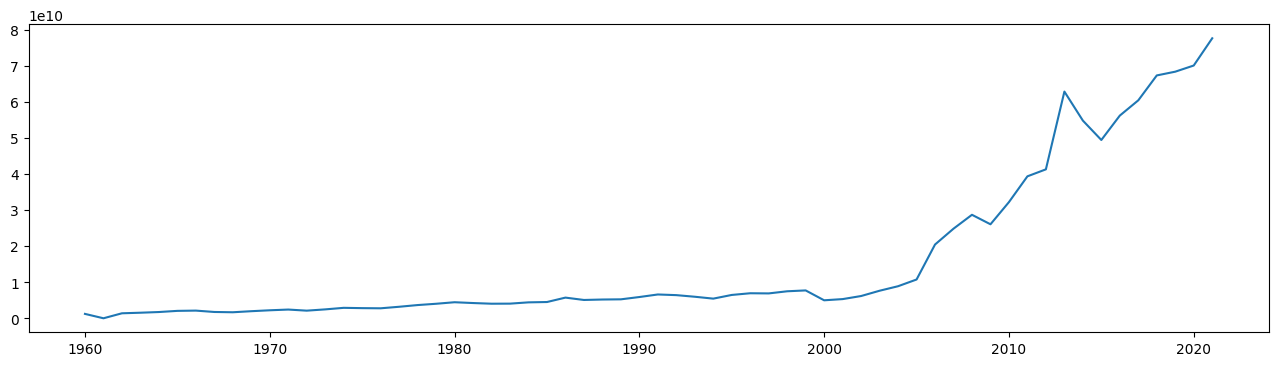

In [68]:
# Визуализация
plt.subplots(figsize=(16, 4))
plt.plot(data);

## Разделение на тренировочную и тестовую выборку

In [69]:
# Отложим последние три года датасета 
# как тестовую выборку для оценки результатов предсказания.
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

## Построим модель скользящего среднего.

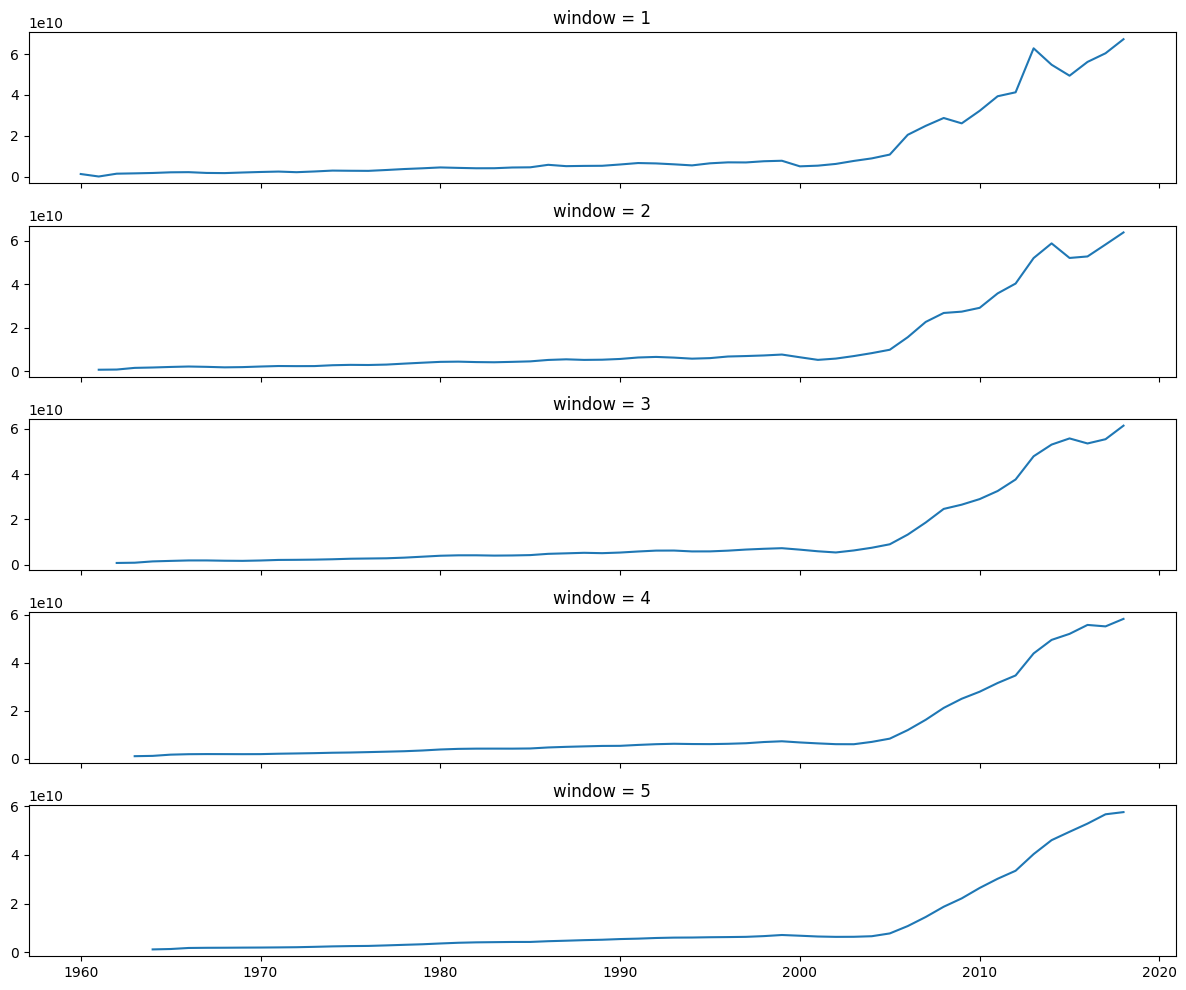

In [70]:
n = 5 # количество значений window
fig, axx = plt.subplots(n, 1, sharex=True, figsize=(12, 10))
for window in range(1, n+1):
    train_ma = train_df.rolling(window).mean()
    plt.sca(axx[window-1])
    plt.plot(train_ma)
    plt.title(f'window = {window}')
plt.tight_layout()
plt.show();

На основании сравнения графиков можно выбрать значение размера окна q = 4.

## Оценим стационарность временного ряда.

In [71]:
result_adf(train_df)

Ряд нестационарен


### Дифференцирование ряда

In [72]:
# Первый порядок
diff_1 = train_df.diff(1).dropna()
result_adf(diff_1)

Ряд нестационарен


In [73]:
# Второй порядок
diff_2 = diff_1.diff(1).dropna()
result_adf(diff_2)

Ряд стационарен для уровня значимости 10%


Исходный временной ряд нестационарен. Порядок дифференцирования d = 2. Следует выбрать модель ARIMA или SARIMA в зависимости от наличия или отсутствия сезонности.  

## Cезонная декомпозиция временного ряда.

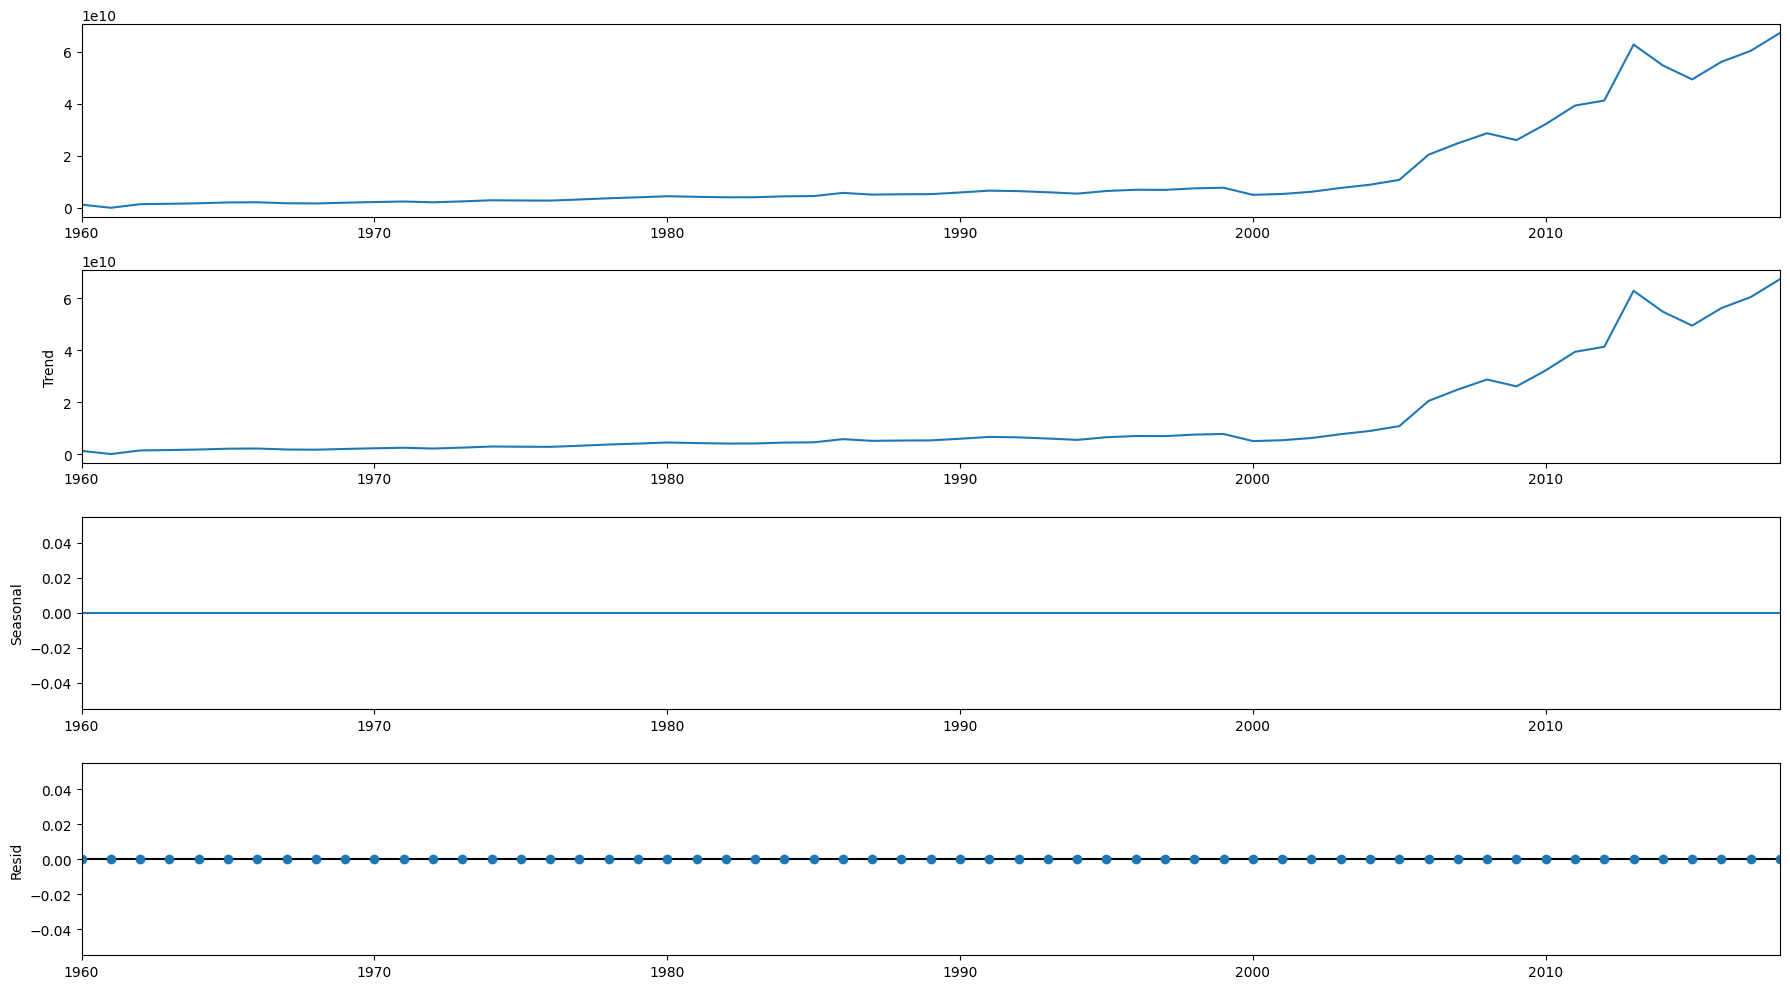

In [74]:
plt.rcParams["figure.figsize"] = 18, 10

result = seasonal_decompose(train_df, model='additive')
result.plot()
plt.show()

Сезонность отсутствует. Выбираем модель ARIMA.  
## Определение параметров p, d, q для модели ARIMA.

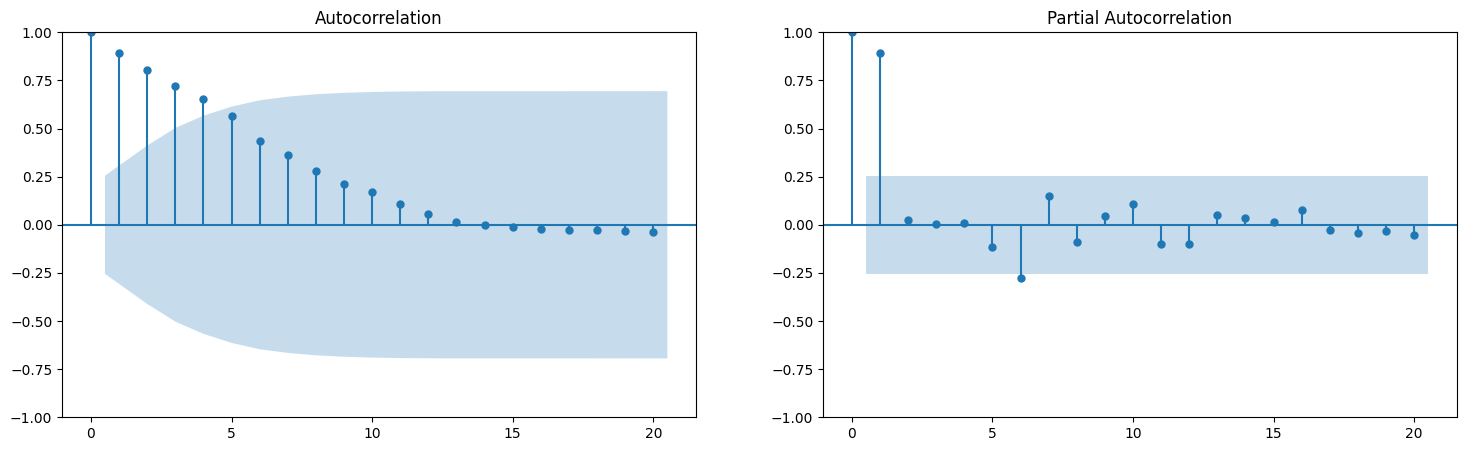

In [75]:
# Строим коррелограммы исходного ряда
plot_acf_pacf(train_df)

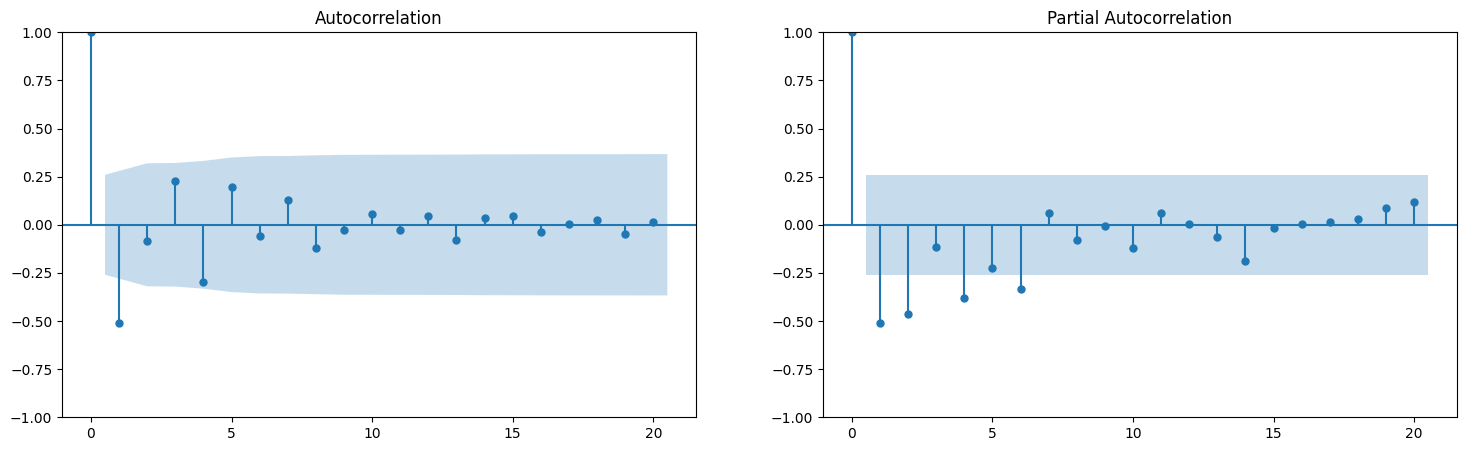

In [76]:
# Строим коррелограммы временного ряда с порядком дифференцирования d=2
plot_acf_pacf(diff_2)

In [77]:
p = 2 # Последний значимый лаг по граффику частичной автокорреляции
d = 2 # По результатам тестов на стационарность
q = 1 # Последний значимый лаг по графика автокорреляции
order = (p, d, q)

На основании кореллограмм выбираем параметры q = 1, p = 2. Порядок дифференцирования d = 2.

### Модель ARIMA с параметрами (order) p=2, d=2, q=1

In [78]:
# Для устранения Warning: No frequency information was provided
train_df.index = pd.DatetimeIndex(train_df.index.values,
                               freq=train_df.index.inferred_freq)

In [79]:

arima_model = ARIMA(train_df, order = order, missing="drop")
arima_model_fit = arima_model.fit()
arima_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1337.891
Date:                Mon, 12 Dec 2022   AIC                           2683.782
Time:                        23:46:58   BIC                           2691.954
Sample:                    01-01-1960   HQIC                          2686.958
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2525      0.230     -1.097      0.273      -0.704       0.199
ar.L2         -0.2149      0.291     -0.740      0.460      -0.785       0.355
ma.L1         -0.8234      0.126     -6.513      0.000      -1.071      -0.576
sigma2      1.835e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               342.07
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):             269.63   Skew:                             1.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.44e+55. Standard errors may be unstable.
"""

### Модель ARIMA с параметрами, ближайшими к (order) p=2, d=2, q=1 . Сравнение коэффициента AIC.  

Проведем оптимизацию гиперпараметров с помощью библиотеки Pyramid ARIMA.

In [80]:
smodel = pm.arima.auto_arima(train_df, 
                            start_p=1,
                            d=2,
                            start_q=1,
                            max_p=3,
                            max_q=5,
                            stationare=False, 
                            seasonal=False,
                            trace=True,
                            error_action='ignore'
                            )
smodel.fit(train_df.dropna())                            
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 12 Dec 2022   AIC                           2680.765
Time:                        23:46:59   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+56. Standard errors may be unstable.
"""

Лучший набор параметров по результатам применения библиотеки Pyramid ARIMA best_order = (1,2,3).

In [81]:
best_order = (1,2,3)

In [82]:
# Построение модели ARIMA с наилучшими параметрами
arima_model_best = ARIMA(train_df.dropna(), order = best_order)
arima_model_best = arima_model_best.fit()
arima_model_best.summary()

/home/as/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 12 Dec 2022   AIC                           2680.765
Time:                        23:46:59   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+56. Standard errors may be unstable.
"""

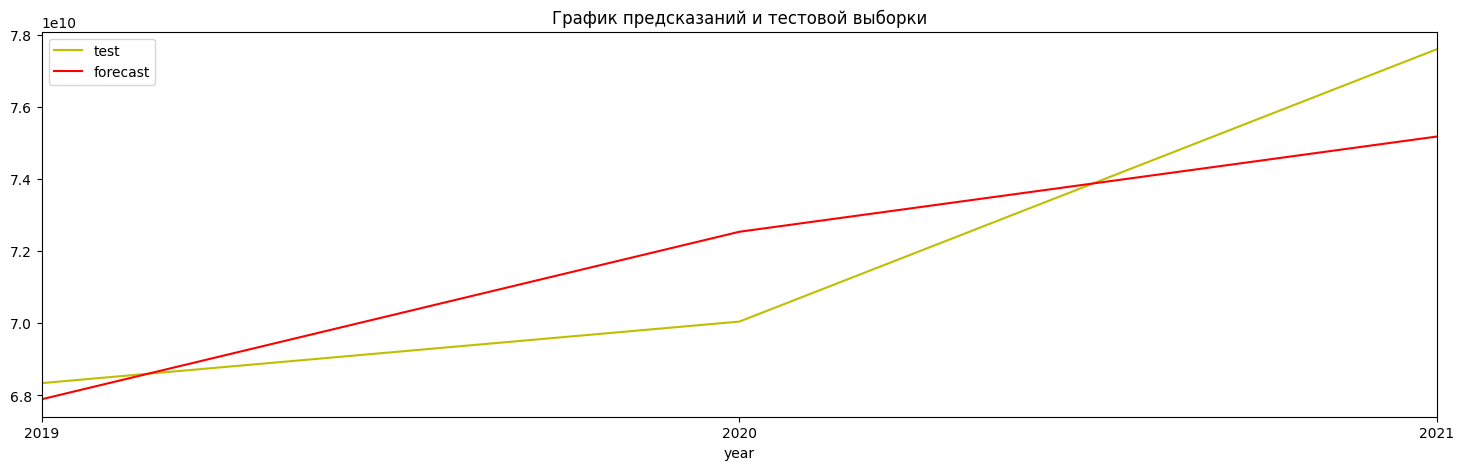

In [83]:
# Предсказание
forecast = arima_model_best.predict(start=len(train_df), end=(len(train_df)+2), dynamic=False)
# Визуализация
test_df.plot(color='y')
forecast.plot(color='r')
plt.title('График предсказаний и тестовой выборки')
plt.legend( ['test', 'forecast']);

In [84]:
# Подготовка данных для визуализации
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = forecast

pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_best.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

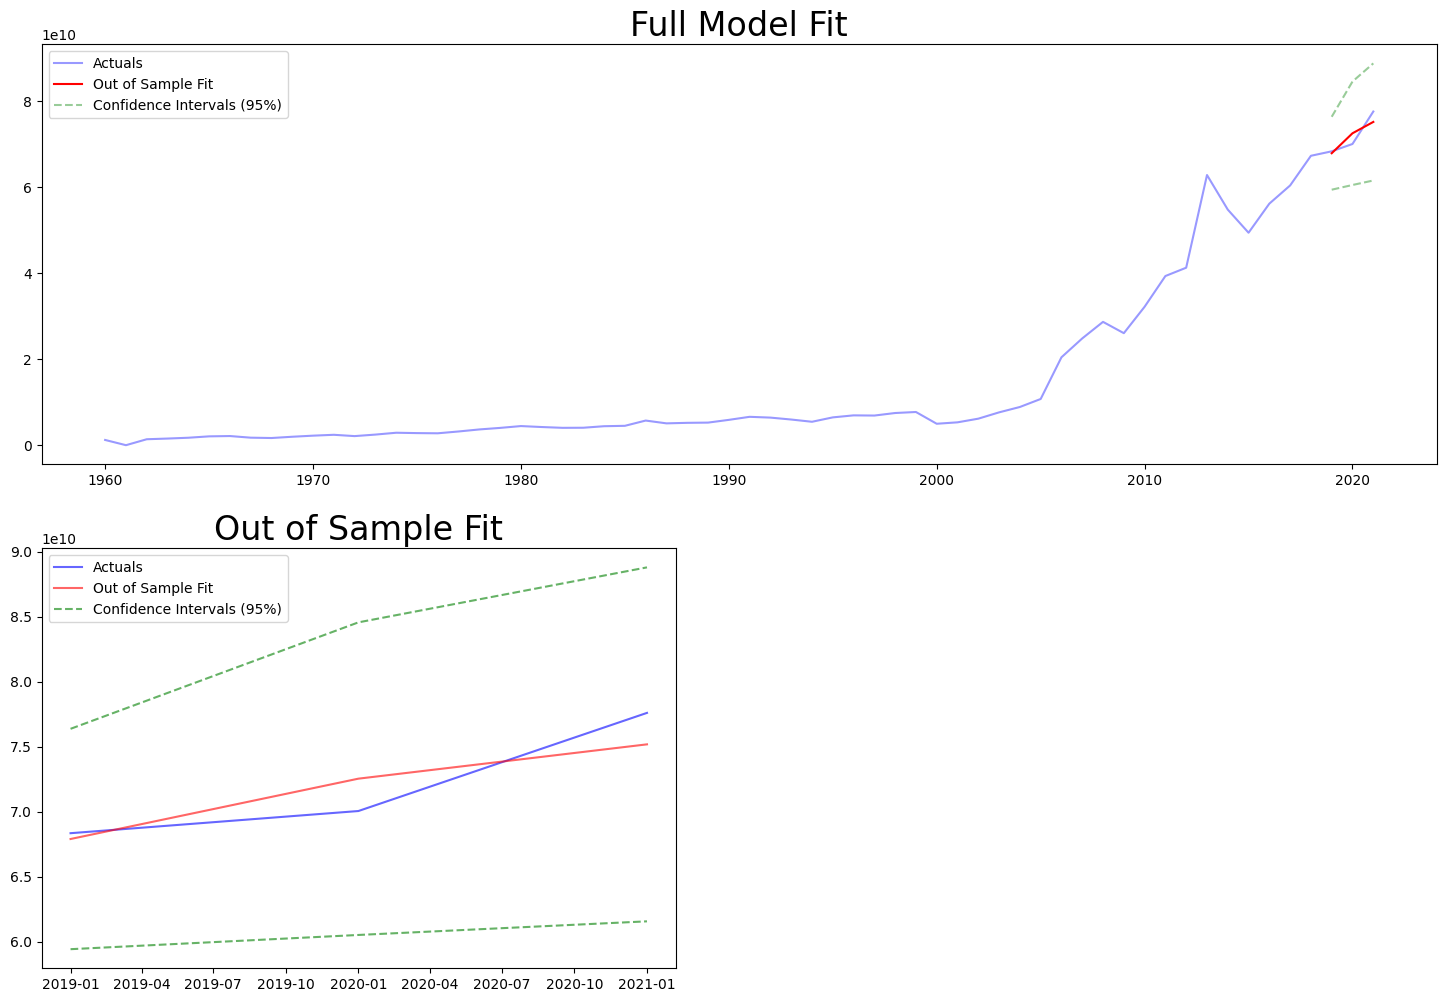

In [85]:
# Визуализация
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["GDP (current US$)"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

**Вывод:**  
- Проведена оценка стационарности и сезонная декомпозиция временного ряда.  
- В результате была выбрана модель ARIMA.  
- По коррелограммам временного ряда были выбраны гиперпараметры модели.  
- Была проведена оптимизация гиперпараметров модели с помощью Pyramid ARIMA.  
- На основе обученной модели сделано предсказание, построен график тестовой выборки и сделанного предсказания.

## Обнаружение и заполнение пропусков в данных

In [86]:
# Если есть пропущенные даты, заполним их nan
df = data.asfreq(freq='AS')
print(f"Количество пропущенных значений {df['GDP (current US$)'].isna().sum()}")

Количество пропущенных значений 0


In [87]:
# Количество нулевых значений
len(np.where(data['GDP (current US$)']==0)[0])
print(f"Количество нулевых значений {len(np.where(data['GDP (current US$)']==0)[0])}")

Количество нулевых значений 1


In [88]:
# Если есть нулевые значения, заполним их nan для последующего заполнения пропусков
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [89]:
# Для заполнения пропусков выполним интерполяцию
df['GDP (current US$)'].interpolate(method='linear', inplace=True)

In [90]:
# Отложим последние три года датасета 
# как тестовую выборку для оценки результатов предсказания.
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

## Оценим стационарность временного ряда.

In [91]:
result_adf(train_df)

Ряд нестационарен


In [92]:
# Первый порядок
diff_1 = train_df.diff(1).dropna()
result_adf(diff_1)

Ряд нестационарен


In [93]:
# Второй порядок
diff_2 = diff_1.diff(1).dropna()
result_adf(diff_2)

Ряд стационарен для уровня значимости 10%


Проведем оптимизацию гиперпараметров с помощью библиотеки Pyramid ARIMA.

In [94]:
smodel = pm.arima.auto_arima(train_df, 
                            start_p=1,
                            d=2,
                            start_q=1,
                            max_p=3,
                            max_q=5,
                            stationare=False, 
                            seasonal=False,
                            trace=True,
                            error_action='ignore'
                            )
smodel.fit(train_df.dropna())                            
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 12 Dec 2022   AIC                           2680.513
Time:                        23:47:01   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+55. Standard errors may be unstable.
"""

Лучший набор параметров по результатам применения библиотеки Pyramid ARIMA best_order = (1,2,3).

In [95]:
best_order = (1,2,3)

In [96]:
# Построение модели ARIMA с наилучшими параметрами
arima_best_model = ARIMA(train_df.dropna(), order = best_order)
arima_best_model = arima_best_model.fit()
arima_best_model.summary()

/home/as/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 12 Dec 2022   AIC                           2680.513
Time:                        23:47:01   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+55. Standard errors may be unstable.
"""

**Вывод:**  
До исключения пропусков в данных показатель AIC для построенной модели ARIMA равнялся 2680,765. После исключения пропусков в данных (посредством интерполяции) показатель AIC для построенной модели ARIMA равняется 2680,513. Показатель AIC снизился, что говорит о негативном влиянии пропусков на качество прогнозирования. Поскольку был убран только 1 пропуск, снижение значения AIC очень мало.

## Кросс-валидация

In [97]:
errors = []  # вектор ошибок

values = df.values

n_splits = 3   # задаём число фолдов для кросс-валидации
test_size = 7  # задаём размер тестовой выборки
# Разбиение данных с помощью TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size) 

# идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
for train, test in tscv.split(df):

    model = ARIMA(values[train], order = best_order).fit()
    forecast = model.predict(start=len(train), end=(len(train)+ test_size-1), dynamic=False)
    actual = values[test]
    error = mean_squared_error(forecast, actual)
    errors.append(error)
errors

/home/as/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/as/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/as/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[6.661719844197248e+19, 2.0632509510912233e+20, 6.537475449635425e+20]

Значения MSE для 3х фолдов близки, можно сделать вывод об отсутствии переобучения модели

# Волатильность 

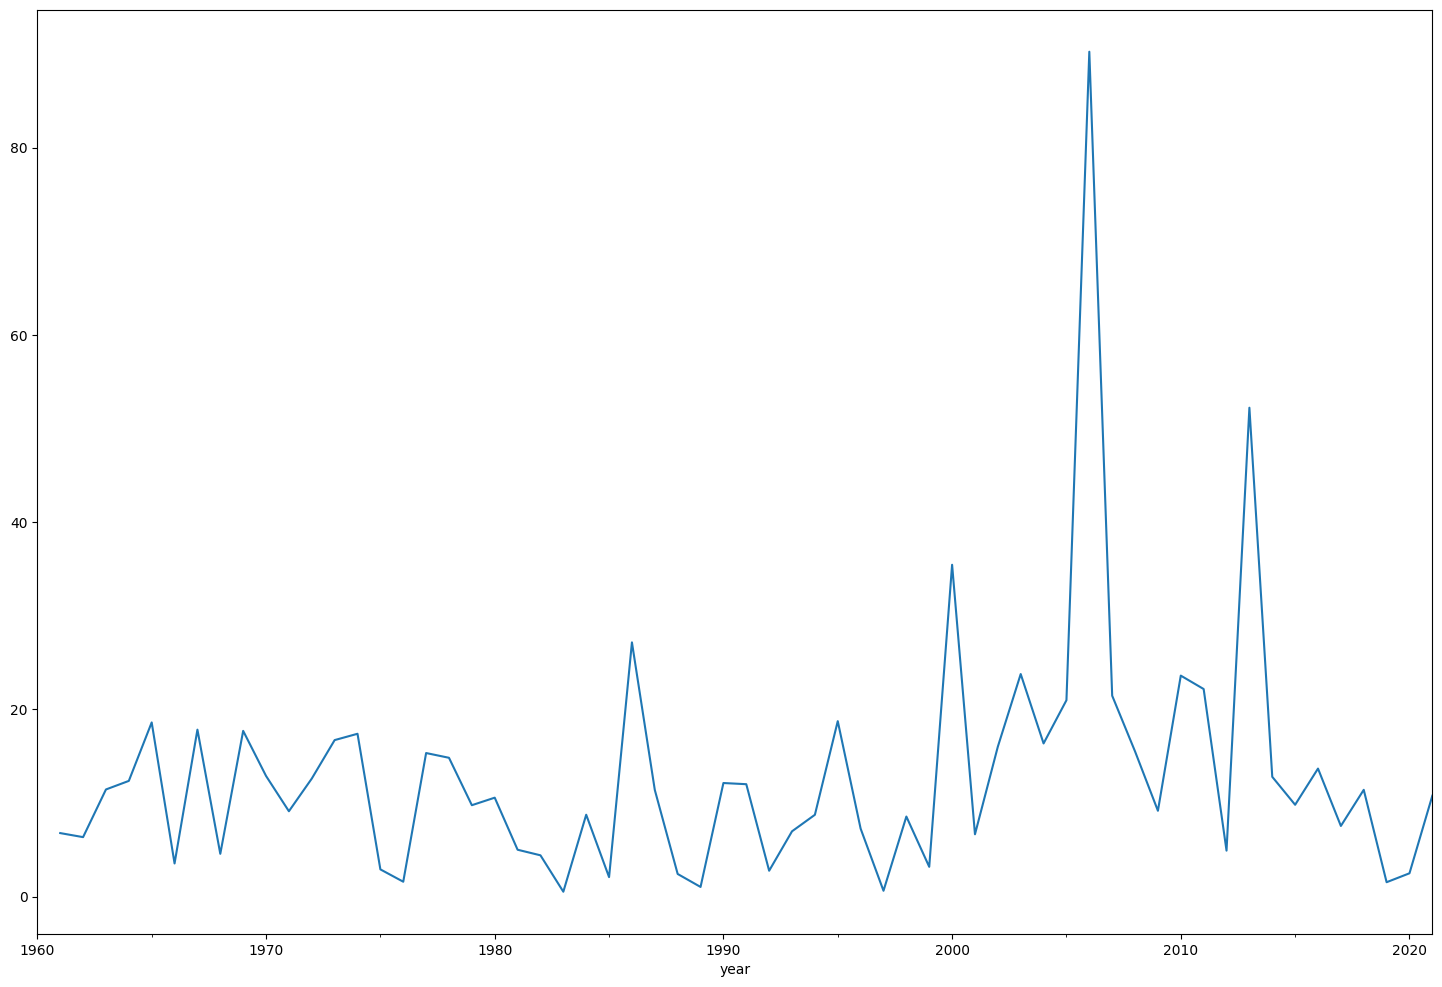

In [98]:
# Оценка волатильности данных
df['vol'] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
data.head()

# Отображение графика волатильности
df['vol'].plot();

## Разделение на тренировочную и тестовую выборку

In [99]:
# Отложим последние три года датасета 
# как тестовую выборку для оценки результатов предсказания.
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
train_df.shape, test_df.shape

((59, 2), (3, 2))

## Оценим стационарность временного ряда.

In [100]:
result_adf(train_df['vol'][1:])

Ряд стационарен для уровня значимости 1%


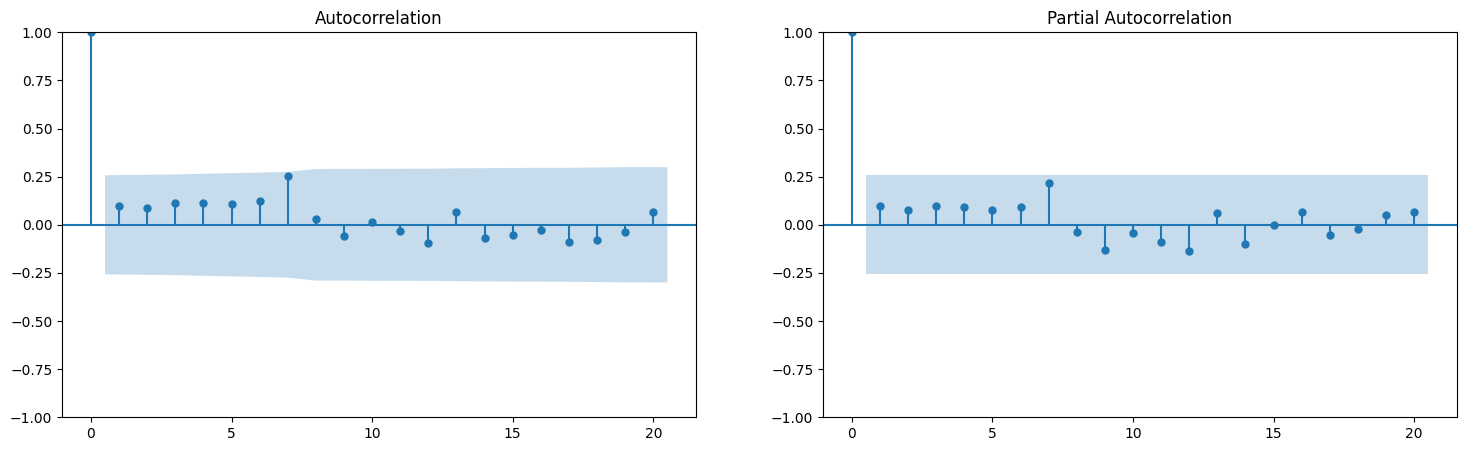

In [101]:
# Строим коррелограммы исходного ряда
plot_acf_pacf(train_df.vol[1:])

In [102]:
# Подготовка данных для использования модели GARCH
garch_df = pd.DataFrame(df['vol'].loc[df.index])
garch_df.loc[train_df.index, 'vol'] = train_df['vol'].dropna()
garch_df.tail(10)

,vol
year,
2012-01-01,4.915536
2013-01-01,52.220960
2014-01-01,12.798164
2015-01-01,9.813800
2016-01-01,13.679567
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746
2020-01-01,2.495937


In [103]:
# Построение модели GARCH
model = arch_model(garch_df.dropna(), p=1, q=1, vol='GARCH')
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)
model_results.summary()


Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18806540888517
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4424.186547219209
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00280717329696
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.5978280754858
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.5978123253653
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Mon, Dec 12 2022   Df Residuals:                       57
Time:                        23:47:02   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3192      2.572      4.790  1.667e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.739      0.148      0.882 [-44.818, 52.158]
alpha[1]       0.0000  9.201e-02      0.000      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.726e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [104]:
# Предсказание по модели GARCH
predictions_df = test_df.copy()
predictions_df['Predictions'] = model_results.forecast().residual_variance.loc[test_df.index]

/home/as/.local/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [105]:
predictions_df

,GDP (current US$),vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,288.546737
2020-01-01,7.004320e+10,2.495937,292.216769
2021-01-01,7.759428e+10,10.780603,295.886802


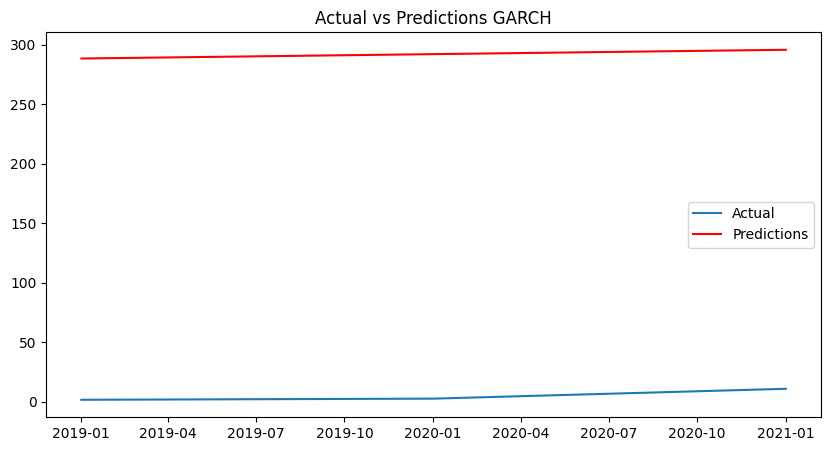

In [106]:
# Построение графиков предсказания и действительных значений на тестовой выборке
plt.rcParams['figure.figsize'] = 10, 5

plt.plot(predictions_df['vol'].abs())
plt.plot(predictions_df['Predictions'], color='red')

plt.title('Actual vs Predictions GARCH')
plt.legend(['Actual', 'Predictions'])
plt.show()

In [107]:
# Оценка ошибки модели GARCH
np.sqrt(mean_squared_error(predictions_df['vol'].abs(), predictions_df['Predictions']))

287.2832493342938

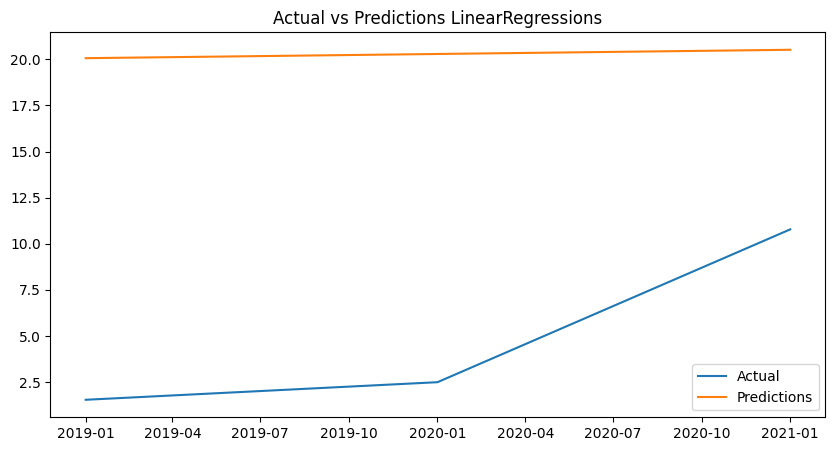

In [108]:
# Реализация модели линейной регрессии
X_train = pd.DataFrame(range(df['vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(df['vol'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['vol'].fillna(0)
y_test = test_df['vol'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.legend(['Actual', 'Predictions'])
plt.title('Actual vs Predictions LinearRegressions')
plt.show()

In [109]:
# Оценка ошибки модели lr
np.sqrt(mean_squared_error(predictions_df['vol'].abs(), lr_predict))

15.85588022673964

**Вывод:**

Автокорреляция для волатильности отсутствует, на графике присутствуют два сильных выброса. Модель GARCH не смогла предсказать дисперсию и показала результат хуже чем модель линейной регрессии. 